# Plot

In [212]:
import pickle, json
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
%config InlineBackend.figure_format='retina'

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
plt.rcParams["text.usetex"] = True
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{times}')
!apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended &> /dev/null0

In [160]:
def copy_data(
    model='resnet18', dataset='cifar10', mode='layer_wise', high_damp=False,
    it=1500, dry_run=True):

    remote_dir = f'/content/drive/MyDrive/grafting/{model}_{dataset}/{mode}'
    local_dir = f'/content/grafting/{model}_{dataset}/{mode}'
    if high_damp:
        local_dir = f'{local_dir}/high_damp'
    !mkdir -p {local_dir}

    files = os.listdir(remote_dir)
    for f in files:
        remote_file_dir = f'{remote_dir}/{f}'
        local_file_dir = f'{local_dir}/{f}'

        if (f.find('high_damp') != -1) != high_damp:
            continue

        if f.endswith('.tar'):            
            print(f'Copying {remote_file_dir} to {local_file_dir}')
            if not dry_run:
                !cp {remote_file_dir} {local_file_dir}
                !tar -xf {local_file_dir} -C {local_dir}
                !rm {local_file_dir}
        else:
            remote_file = f'{remote_file_dir}/log_loss_{f}_{it}.txt'
            
            print(f'Copying {remote_file} to {local_file_dir}')
            if not dry_run:
                !mkdir -p {local_file_dir}
                !cp {remote_file} {local_file_dir}

In [ ]:
copy_data(high_damp=False, dry_run=False)
copy_data(high_damp=True, dry_run=False)
copy_data(model='dcnet', dataset='mnist', it=500, dry_run=False)

In [4]:
def load(
    mag_opt, dir_opt, it=1500, model='resnet18', dataset='cifar10', 
    mode='layer_wise', high_damp=False):

    # This is the default loading directory
    identif = f'{mag_opt}#{dir_opt}'  # Identifier for the experiment
    load_dir = f'/content/grafting/{model}_{dataset}/{mode}'
    if high_damp:
        load_dir = f'{load_dir}/high_damp'

    with open(f'{load_dir}/{identif}/log_loss_{identif}_{it}.txt', 'r') as f:
        hists = json.load(f)[f'{mag_opt}#{dir_opt}']
        
        losses = np.array(hists['losses'])
        val_metric = np.array(hists['val_metric'])
        mag_m = np.array(hists['mag_m'])
        mag_d = np.array(hists['mag_d'])
        mag_inflate = np.array(hists['mag_inflate'])
        cos_sim = np.array(hists['cos_sim'])

    return losses, val_metric, mag_m, mag_d, mag_inflate, cos_sim

In [213]:
# Define styles that will be used for every plot
cs = {'sgd': 'b', 'adam': 'r', 'kfac': 'g', 'hf': 'y'}
fmts = {'sgd': '-', 'adam': '--', 'kfac': ':', 'hf': '-.'}
disp_name = {'sgd': 'SGD', 'adam': 'Adam', 'kfac': 'K-FAC', 'hf': 'HF'}

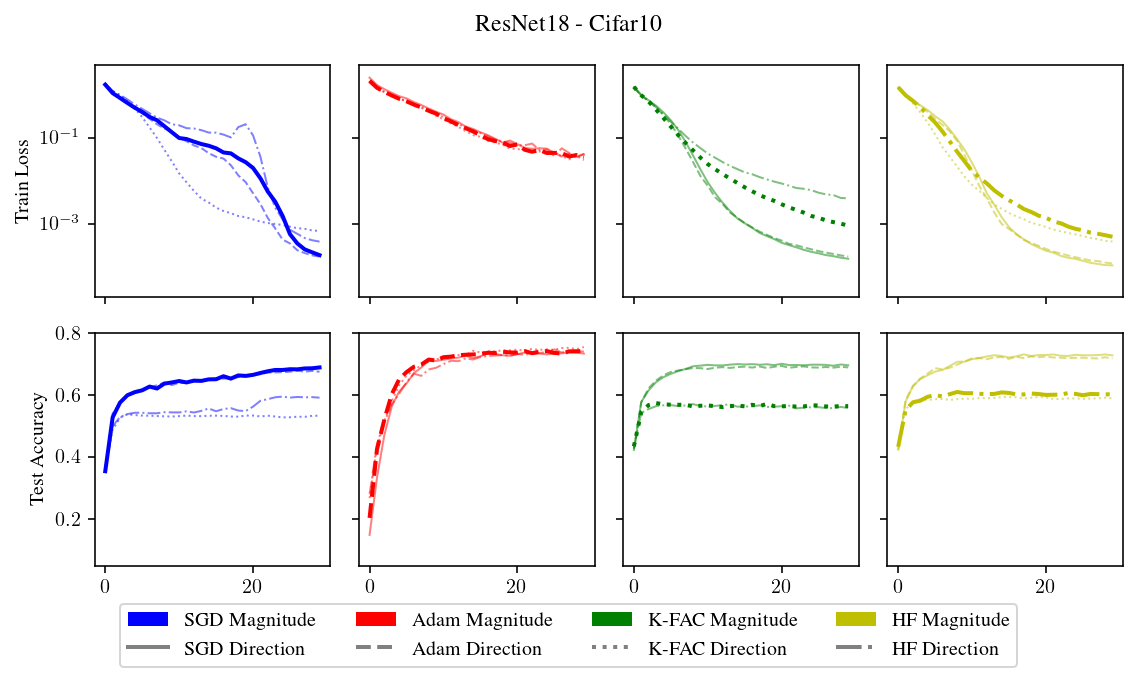

In [186]:
fig, axs = plt.subplots(
    2, 4, figsize=(2*4*1, 2*2*1), sharex=True, sharey='row')

suptitle = fig.suptitle('ResNet18 - Cifar10', y=1.05)
for M_opt, (ax1, ax2) in zip(['sgd', 'adam', 'kfac', 'hf'], zip(*axs)):
    for D_opt in ['sgd', 'adam', 'kfac', 'hf']:
        alpha = 0.5
        linewidth = 1.0
        if M_opt == D_opt:
            alpha = 1.0
            linewidth = 2.0
        
        high_damp = (M_opt == 'hf' or D_opt == 'hf')
        train_loss, val_metric, *_ = load(M_opt, D_opt, high_damp=high_damp)

        # Average over 50 runs (~1 epoch)
        train_loss = np.average(train_loss[:-1].reshape((-1, 50)), axis=1)
        val_metric = np.average(val_metric[:-1].reshape((-1, 50)), axis=1)

        ax1.plot(
            train_loss, f'{cs[M_opt]}{fmts[D_opt]}', linewidth=linewidth,
            alpha=alpha)
        ax2.plot(
            val_metric, f'{cs[M_opt]}{fmts[D_opt]}', linewidth=linewidth,
            alpha=alpha)
        
        ax1.set_yscale('log')
        ax1.set_ylim([2e-5, 5])
        ax2.set_ylim([0.05, 0.8])


legend_elements = [Patch(facecolor=cs[k], label=f'{disp_name[k]} Magnitude') \
                   for k in ['sgd', 'adam', 'kfac', 'hf']]

legend_elements += [Line2D(
    [0], [0], ls=fmts[k], lw=2, c='gray', label=f'{disp_name[k]} Direction') \
    for k in ['sgd', 'adam', 'kfac', 'hf']]

axs[0][0].set_ylabel('Train Loss')
axs[1][0].set_ylabel('Test Accuracy')

legend_elements = [[legend_elements[i], legend_elements[4+i]] for i in range(4)]
legend_elements = [t for l in legend_elements for t in l]

lgd = fig.legend(
    handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1),
    bbox_transform=fig.transFigure, ncol=4)

fig.tight_layout()
fig.savefig(
    'high_damp.pdf', bbox_extra_artists=(suptitle, lgd,), 
    bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7

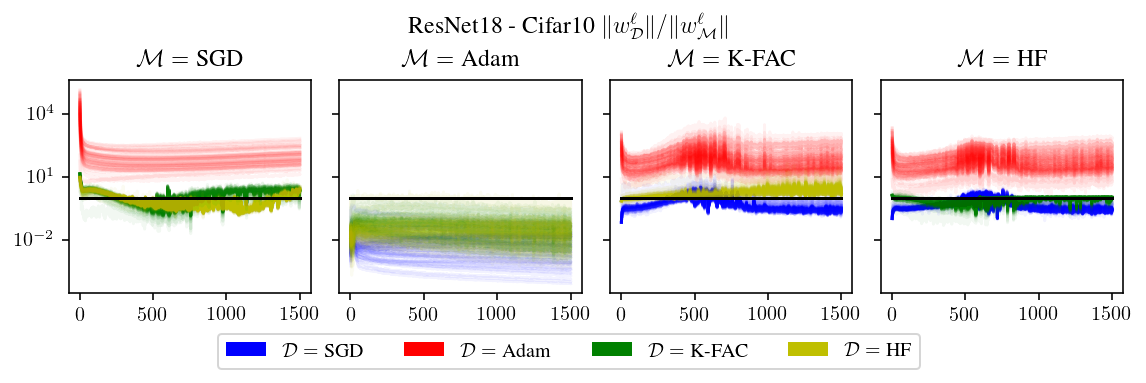

In [187]:
fig, axs = plt.subplots(
    1, 4, figsize=(2*4*1, 1.1*2*1), sharex=True, sharey='row')

suptitle = fig.suptitle(
    r'ResNet18 - Cifar10 $\|w_\mathcal{D}^\ell\|/\|w_\mathcal{M}^\ell\|$', 
    y=1.05)
for M_opt, ax in zip(['sgd', 'adam', 'kfac', 'hf'], axs):
    for D_opt in ['sgd', 'adam', 'kfac', 'hf']:
        if M_opt == D_opt:
            continue
        
        high_damp = (M_opt == 'hf' or D_opt == 'hf')
        _, _, mag_m, mag_d, *_ = load(M_opt, D_opt, high_damp=high_damp)
        ax.plot(mag_d / mag_m, f'{cs[D_opt]}', alpha=0.05)
        
        ax.set_yscale('log')

    ax.set_title(f'$\mathcal{{M}}=\\text{{{disp_name[M_opt]}}}$')
    ax.plot([0, 1500], [1, 1], 'k')

legend_elements = [Patch(facecolor=cs[k], label=f'$\mathcal{{D}}=\\text{{{disp_name[k]}}}$') \
                   for k in ['sgd', 'adam', 'kfac', 'hf']]

lgd = fig.legend(
    handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1),
    bbox_transform=fig.transFigure, ncol=4)

fig.tight_layout()
fig.savefig(
    'high_damp_norms.pdf', bbox_extra_artists=(suptitle, lgd,), 
    bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7

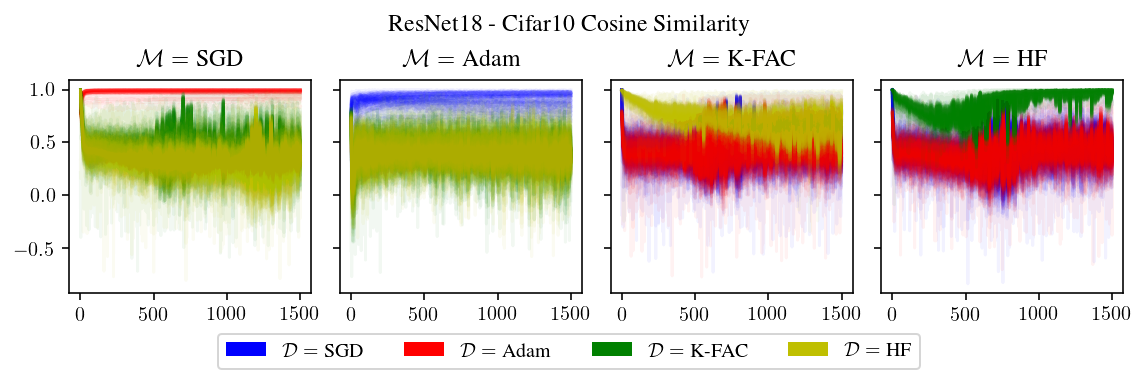

In [188]:
fig, axs = plt.subplots(
    1, 4, figsize=(2*4, 1.1*2), sharex=True, sharey='row')

suptitle = fig.suptitle(r'ResNet18 - Cifar10 Cosine Similarity', y=1.05)
for M_opt, ax in zip(['sgd', 'adam', 'kfac', 'hf'], axs):
    for D_opt in ['sgd', 'adam', 'kfac', 'hf']:
        if M_opt == D_opt:
            continue
        
        high_damp = (M_opt == 'hf' or D_opt == 'hf')
        _, _, mag_m, mag_d, _, cos_sim = load(M_opt, D_opt, high_damp=high_damp)
        cos_sim = cos_sim * (1e-8 + mag_m * mag_d) / (mag_m * mag_d)
        ax.plot(cos_sim, f'{cs[D_opt]}', alpha=0.05)

    ax.set_title(f'$\mathcal{{M}}=\\text{{{disp_name[M_opt]}}}$')

legend_elements = [Patch(facecolor=cs[k], label=f'$\mathcal{{D}}=\\text{{{disp_name[k]}}}$') \
                   for k in ['sgd', 'adam', 'kfac', 'hf']]

lgd = fig.legend(
    handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1),
    bbox_transform=fig.transFigure, ncol=4)

fig.tight_layout()
fig.savefig(
    'high_damp_cos.pdf', bbox_extra_artists=(suptitle, lgd,), 
    bbox_inches='tight')
plt.show()

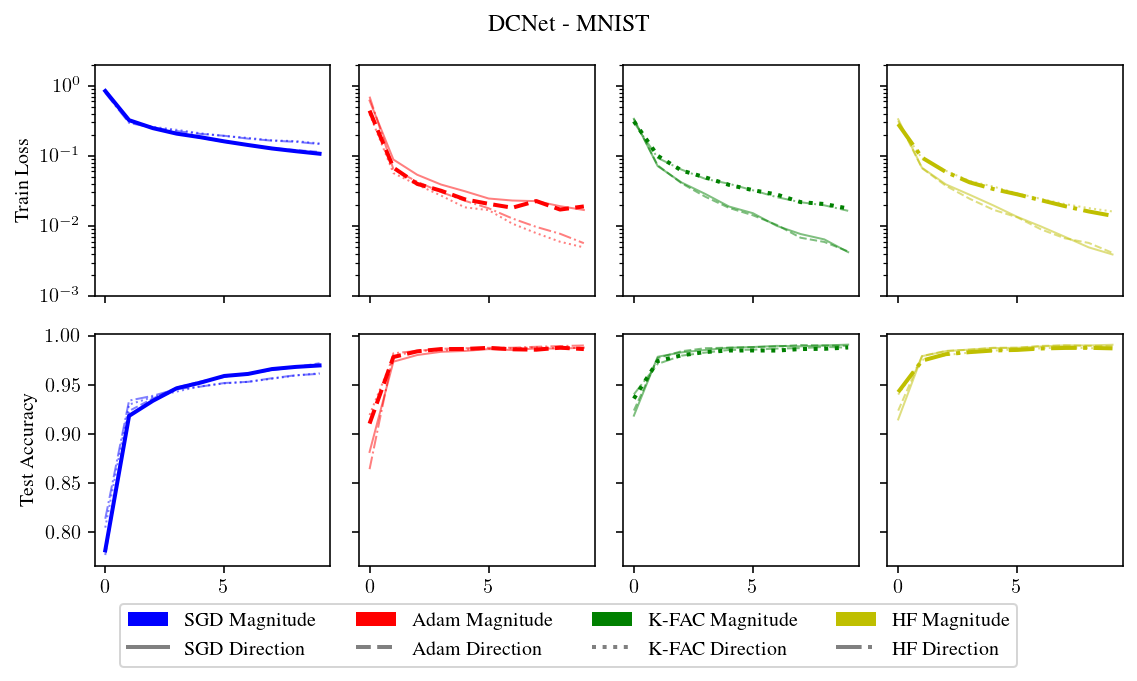

In [189]:
fig, axs = plt.subplots(
    2, 4, figsize=(2*4*1, 2*2*1), sharex=True, sharey='row')

suptitle = fig.suptitle('DCNet - MNIST', y=1.05)
for M_opt, (ax1, ax2) in zip(['sgd', 'adam', 'kfac', 'hf'], zip(*axs)):
    for D_opt in ['sgd', 'adam', 'kfac', 'hf']:
        alpha = 0.5
        linewidth = 1.0
        if M_opt == D_opt:
            alpha = 1.0
            linewidth = 2.0
        
        train_loss, val_metric, *_ = load(
            M_opt, D_opt, model='dcnet', dataset='mnist', it=500)

        # Average over 50 runs (~1 epoch)
        train_loss = np.average(train_loss[:-1].reshape((-1, 50)), axis=1)
        val_metric = np.average(val_metric[:-1].reshape((-1, 50)), axis=1)

        ax1.plot(
            train_loss, f'{cs[M_opt]}{fmts[D_opt]}', linewidth=linewidth,
            alpha=alpha)
        ax2.plot(
            val_metric, f'{cs[M_opt]}{fmts[D_opt]}', linewidth=linewidth,
            alpha=alpha)
        
        ax1.set_yscale('log')
        ax1.set_ylim([1e-3, 2])

legend_elements = [Patch(facecolor=cs[k], label=f'{disp_name[k]} Magnitude') \
                   for k in ['sgd', 'adam', 'kfac', 'hf']]

axs[0][0].set_ylabel('Train Loss')
axs[1][0].set_ylabel('Test Accuracy')

legend_elements += [Line2D(
    [0], [0], ls=fmts[k], lw=2, c='gray', label=f'{disp_name[k]} Direction') \
    for k in ['sgd', 'adam', 'kfac', 'hf']]

legend_elements = [[legend_elements[i], legend_elements[4+i]] for i in range(4)]
legend_elements = [t for l in legend_elements for t in l]

lgd = fig.legend(
    handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1),
    bbox_transform=fig.transFigure, ncol=4)

fig.tight_layout()
fig.savefig(
    'dcnet.pdf', bbox_extra_artists=(suptitle, lgd,), 
    bbox_inches='tight')
plt.show()

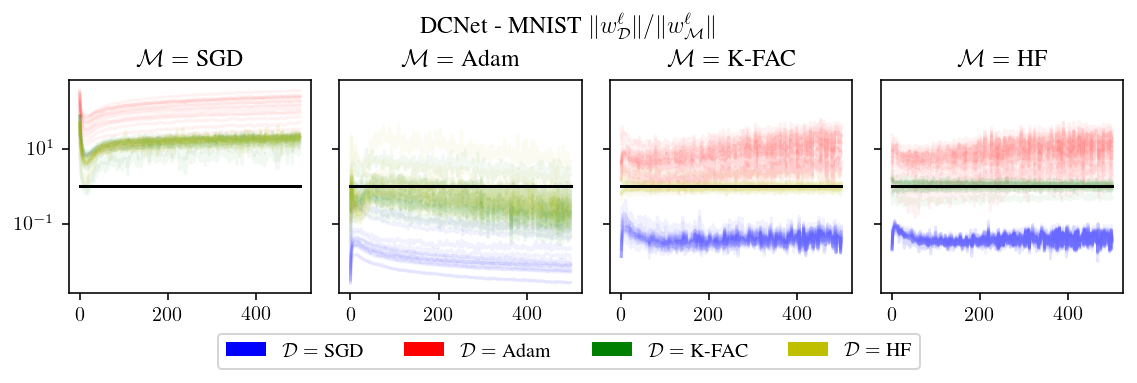

In [191]:
fig, axs = plt.subplots(
    1, 4, figsize=(2*4*1, 1.1*2*1), sharex=True, sharey='row')

suptitle = fig.suptitle(
    r'DCNet - MNIST $\|w_\mathcal{D}^\ell\|/\|w_\mathcal{M}^\ell\|$', y=1.05)
for M_opt, ax in zip(['sgd', 'adam', 'kfac', 'hf'], axs):
    for D_opt in ['sgd', 'adam', 'kfac', 'hf']:
        if M_opt == D_opt:
            continue
        
        _, _, mag_m, mag_d, *_ = load(
            M_opt, D_opt, high_damp=False, model='dcnet', 
            dataset='mnist', it=500)
        ax.plot(mag_d / mag_m, f'{cs[D_opt]}', alpha=0.05)
        
        ax.set_yscale('log')

    ax.set_title(f'$\mathcal{{M}}=\\text{{{disp_name[M_opt]}}}$')
    ax.plot([0, 500], [1, 1], 'k')

legend_elements = [Patch(facecolor=cs[k], label=f'$\mathcal{{D}}=\\text{{{disp_name[k]}}}$') \
                   for k in ['sgd', 'adam', 'kfac', 'hf']]

lgd = fig.legend(
    handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1),
    bbox_transform=fig.transFigure, ncol=4)

fig.tight_layout()
fig.savefig(
    'dcnet_norms.pdf', bbox_extra_artists=(suptitle, lgd,), 
    bbox_inches='tight')
plt.show()

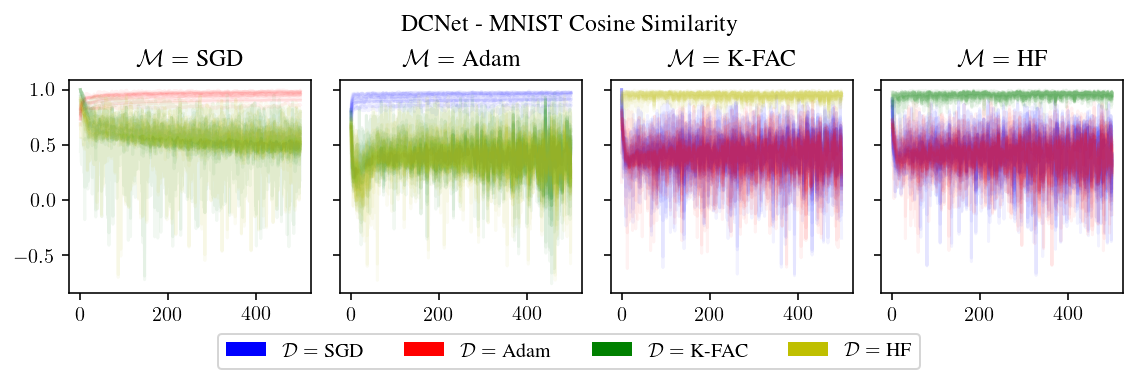

In [192]:
fig, axs = plt.subplots(
    1, 4, figsize=(2*4*1, 1.1*2*1), sharex=True, sharey='row')

suptitle = fig.suptitle(r'DCNet - MNIST Cosine Similarity', y=1.05)
for M_opt, ax in zip(['sgd', 'adam', 'kfac', 'hf'], axs):
    for D_opt in ['sgd', 'adam', 'kfac', 'hf']:
        if M_opt == D_opt:
            continue
        
        _, _, mag_m, mag_d, _, cos_sim = load(
            M_opt, D_opt, model='dcnet', dataset='mnist', it=500)
        cos_sim = cos_sim * (1e-8 + mag_m * mag_d) / (mag_m * mag_d)
        ax.plot(cos_sim, f'{cs[D_opt]}', alpha=0.05)
        
    ax.set_title(f'$\mathcal{{M}}=\\text{{{disp_name[M_opt]}}}$')

legend_elements = [Patch(
    facecolor=cs[k], label=f'$\mathcal{{D}}=\\text{{{disp_name[k]}}}$') \
    for k in ['sgd', 'adam', 'kfac', 'hf']]

lgd = fig.legend(
    handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1),
    bbox_transform=fig.transFigure, ncol=4)

fig.tight_layout()
fig.savefig(
    'dcnet_cos.pdf', bbox_extra_artists=(suptitle, lgd,), 
    bbox_inches='tight')
plt.show()

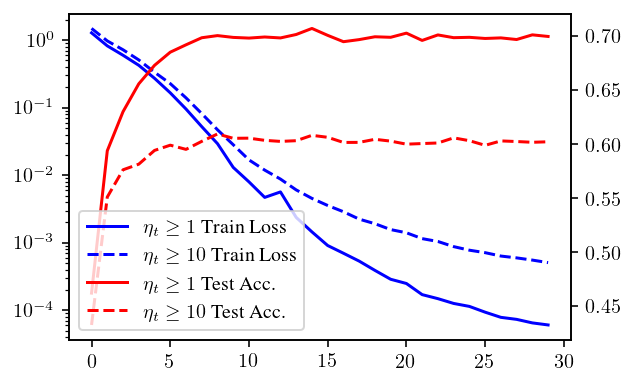

In [211]:
hf_train_loss_hist, hf_val_acc_hist, *_ = load('hf', 'hf')
hf_train_loss_hist_high, hf_val_acc_hist_high, *_ = load(
    'hf', 'hf', high_damp=True)

hf_train_loss_hist = np.average(
    hf_train_loss_hist[:-1].reshape((-1, 50)), axis=-1)
hf_val_acc_hist = np.average(
    hf_val_acc_hist[:-1].reshape((-1, 50)), axis=-1)
hf_train_loss_hist_high = np.average(
    hf_train_loss_hist_high[:-1].reshape((-1, 50)), axis=-1)
hf_val_acc_hist_high = np.average(
    hf_val_acc_hist_high[:-1].reshape((-1, 50)), axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(6*0.75, 4*0.75))
line1, = ax.plot(hf_train_loss_hist, 'b', label='$\eta_t\geq 1$ Train Loss')
line2, = ax.plot(hf_train_loss_hist_high, 'b--', label='$\eta_t\geq 10$ Train Loss')
# ax.set_ylabel('Training Loss')
ax.set_yscale('log')
ax = ax.twinx()
line3, = ax.plot(hf_val_acc_hist, 'r', label='$\eta_t\geq 1$ Test Acc.')
line4, = ax.plot(hf_val_acc_hist_high, 'r--', label='$\eta_t\geq 10$ Test Acc.')
# ax.set_ylabel('Test Accuracy')
ax.legend(handles=[line1, line2, line3, line4], loc='lower left', ncol=1)
fig.savefig('damping.pdf', bbox_inches='tight')
plt.show()